In [1]:
!pip install -Uqq fastai duckduckgo_search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 69.6 MB/s eta 0:00:00


In [4]:
from duckduckgo_search import AsyncDDGS

from fastcore.all import *

async def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    results =  AsyncDDGS().images(keywords=term, region='wt-wt', safesearch='off', max_results=max_images)
    #print(f"results '{results[0]}'")
    return L(results).itemgot('image')

In [5]:
results = await search_images('bird photos', max_images=1)
print(f"results '{results}'")

Searching for 'bird photos'
results '['https://images.pexels.com/photos/326900/pexels-photo-326900.jpeg?cs=srgb&dl=wood-flight-bird-326900.jpg&fm=jpg']'


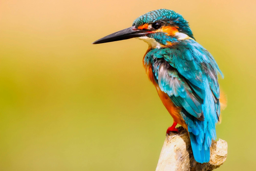

In [6]:
from fastdownload import download_url
dest = 'bird.jpg'
#results_list = list(results[0].items())
#print(list(results[0].values())[1])
download_url(results[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'forest photos'


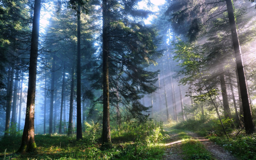

In [7]:
download_url((await search_images('forest photos', max_images=1))[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

In [8]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls= (await search_images(f'{o} photo')) )
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=(await search_images(f'{o} sun photo')))
    sleep(10)
    download_images(dest, urls=(await search_images(f'{o} shade photo')))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


In [9]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

3

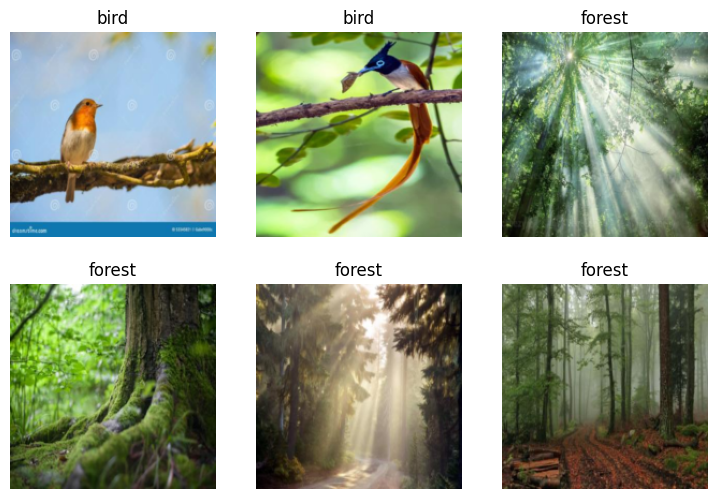

In [10]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [11]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 78.3MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.899500,0.183003,0.088235,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.168804,0.002371,0.000000,00:01
1,0.117153,0.000400,0.000000,00:01
2,0.078884,0.000722,0.000000,00:01


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [12]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 0.9999
